In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from argparse import Namespace
import misc.logging_utils as logging_utils

args = Namespace()
logger = logging_utils.get_ipython_logger()

In [9]:
import numpy as np
import networkx as nx

import misc.automl_utils as automl_utils
import misc.parallel as parallel
import misc.utils as utils

import as_auto_sklearn.as_asl_command_line_utils as clu
import as_auto_sklearn.as_asl_filenames as filenames
import as_auto_sklearn.as_asl_utils as as_asl_utils
from as_auto_sklearn.as_asl_ensemble import ASaslPipeline

from as_auto_sklearn.presolver_scheduler import PresolverScheduler


In [4]:
args.training_scenarios_dir = "/mldb/oasc_scenarios/train/"
training_scenarios = automl_utils.load_all_scenarios(args.training_scenarios_dir)

INFO     : Read ASlib scenario: /mldb/oasc_scenarios/train/Bado
INFO     : Read /mldb/oasc_scenarios/train/Bado/description.txt
INFO     : Read /mldb/oasc_scenarios/train/Bado/algorithm_runs.arff
INFO     : Read /mldb/oasc_scenarios/train/Bado/feature_values.arff
INFO     : Read /mldb/oasc_scenarios/train/Bado/feature_runstatus.arff
INFO     : Read /mldb/oasc_scenarios/train/Bado/feature_costs.arff
INFO     : Read /mldb/oasc_scenarios/train/Bado/cv.arff
DEBUG    : Replace all runtime data with PAR10 values for non-OK runs
INFO     : Read ASlib scenario: /mldb/oasc_scenarios/train/Camilla
INFO     : Read /mldb/oasc_scenarios/train/Camilla/description.txt
DEBUG    : Since we optimize quality, we use runtime cutoff of 1.
INFO     : Read /mldb/oasc_scenarios/train/Camilla/algorithm_runs.arff
INFO     : Read /mldb/oasc_scenarios/train/Camilla/feature_values.arff
       'instance_85'],
      dtype='object', name='instance_id')
INFO     : Read /mldb/oasc_scenarios/train/Camilla/feature_runsta

INFO     : Read /mldb/oasc_scenarios/train/Quill/feature_costs.arff
INFO     : Read /mldb/oasc_scenarios/train/Quill/cv.arff
DEBUG    : Replace all runtime data with PAR10 values for non-OK runs
INFO     : Read ASlib scenario: /mldb/oasc_scenarios/train/Sora
INFO     : Read /mldb/oasc_scenarios/train/Sora/description.txt
INFO     : Read /mldb/oasc_scenarios/train/Sora/algorithm_runs.arff
INFO     : Read /mldb/oasc_scenarios/train/Sora/feature_values.arff
INFO     : Read /mldb/oasc_scenarios/train/Sora/feature_runstatus.arff
INFO     : Read /mldb/oasc_scenarios/train/Sora/feature_costs.arff
INFO     : Read /mldb/oasc_scenarios/train/Sora/cv.arff
DEBUG    : Replace all runtime data with PAR10 values for non-OK runs
INFO     : Read ASlib scenario: /mldb/oasc_scenarios/train/Svea
INFO     : Read /mldb/oasc_scenarios/train/Svea/description.txt
INFO     : Read /mldb/oasc_scenarios/train/Svea/algorithm_runs.arff
INFO     : Read /mldb/oasc_scenarios/train/Svea/feature_values.arff
       'insta

In [43]:
scenario = training_scenarios['Svea']
feature_dependency_graph = automl_utils.extract_feature_step_dependency_graph(scenario)
feature_topo_order = nx.topological_sort(feature_dependency_graph)

In [52]:
automl_utils.add_automl_values_to_args(args, total_training_time=20)

In [78]:
import mlxtend.feature_selection
from sklearn.utils.validation import check_is_fitted

from as_auto_sklearn.as_asl_ensemble import ASaslPipeline
from as_auto_sklearn.validate import Validator

import misc.automl_utils as automl_utils

class SequentialFeatureStepSelector:
    """ This class uses a greedy, forward sequential feature search
    to select the optimal set of feature steps. Conceptually, it is
    essentially the same as the SequentialFeatureSelector from mlxtend:
    
        https://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/
        
    However, it includes the following differences:
    
    * It is tailored to work for the feature steps as defined for
      ASlib scenarios. Namely, it includes groups of features at
      a time, and it ensures feature dependencies are respected.
      
    * It specifically uses PAR10 as the selection criterion.
      
    * It only supports forward search.
    
    * It never places any feature steps on an "exclude" list.
    """
    def __init__(self, args, max_feature_steps=np.inf):
        self.args = args
        self.max_feature_steps = max_feature_steps
    
    def _get_par10(self, feature_steps):
        
        total_par10 = 0.0
        total_timeouts = 0
        total_solved = 0
        
        for fold in self.args.folds:

            # first, split the scenario into training and testing
            testing, training = scenario.get_split(fold)

            # construct and fit a pipeline with the indicated feature steps
            pipeline = ASaslPipeline(args, feature_steps=feature_steps)
            pipeline_fit = pipeline.fit(scenario=training)
            
            # now, check the par10 both with and without presolving
            min_par10 = np.inf
            
            for enable_presolving in [True, False]:
                schedules = pipeline_fit.create_solver_schedules(testing, enable_presolving)

                # use par10 to evaluate the pipeline
                validator = Validator()
                if scenario.performance_type[0] == "runtime":
                    stat = validator.validate_runtime(schedules=schedules, test_scenario=testing, show=True)
                else:
                    stat = validator.validate_quality(schedules=schedules, test_scenario=testing, show=True)
                    
                if stat.par10 < min_par10:
                    min_par10 = stat.par10
                
            total_par10 += min_par10
            
            # these don't really matter. we just need them for normalization
            total_timeouts += stat.timeouts
            total_solved += stat.solved

        total = total_timeouts + total_solved
        total_par10 = total_par10 / total

        return total_par10

    def _find_best_feature_step(self):
        """ Based on the current set of included feature steps, find
        the next best one to include
        """

        best_feature_step = None
        best_par10 = np.inf

        for feature_step in self.remaining_feature_steps_:
            test_feature_steps = self.cur_feature_steps_ + [feature_step]

            if not automl_utils.check_all_dependencies(self.scenario, test_feature_steps):
                continue

            test_par10 = self._get_par10(test_feature_steps)
            if test_par10 < best_par10:
                best_par10 = test_par10
                best_feature_step = feature_step

        return (best_feature_step, best_par10)
        
    def fit(self, scenario):
        """ Select the optimal set of feature steps according to PAR10
        
        Parameters
        ----------
        scenario: ASlibScenario
            The scenario
            
        Returns
        -------
        self
        """
        self.scenario = scenario
        self.cur_feature_steps_ = []
        self.cur_par10_ = np.inf

        # make sure to use a copy
        self.remaining_feature_steps_ = list(scenario.feature_steps)

        while len(self.cur_feature_steps_) <= self.max_feature_steps:
            (best_feature_step, best_par10) = self._find_best_feature_step()

            if best_par10 > self.cur_par10_:
                break

            self.cur_feature_steps_.append(best_feature_step)
            self.remaining_feature_steps_.remove(best_feature_step)

            self.cur_par10_ = best_par10
            
        return self
    
    def get_transformer(self):
        """ Get a ColumnSelector based on the selected feature steps
        """
        
        check_is_fitted(self, "cur_feature_steps_")
        
        selected_features = automl_utils.extract_feature_names(
            self.scenario, 
            self.cur_feature_steps_
        )
            
        feature_selector = mlxtend.feature_selection.ColumnSelector(
            cols=selected_features)
        
        return feature_selector

In [79]:
args.num_cpus = 1
args.folds = [8, 10]
args.presolver_budget = 0.001
args.presolver_min_fast_solutions = 0.5

In [ ]:
scenario = training_scenarios['Bado']
sfss = SequentialFeatureStepSelector(args, max_feature_steps=3)
sfss_fit = sfss.fit(scenario)
sfss.cur_feature_steps_, sfss.cur_par10_

Time limit for a single run is higher than total time limit. Capping the limit for a single run to the total time given to SMAC (19.551478)
[WARNING] [2017-08-29 01:51:50,680:AutoMLSMBO(8675309)::c01a88f14ba24a818c4f75e0e9f4f0d8] Could not find meta-data directory /home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/metalearning/files/mean_squared_error_regression_dense


/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/smbo.py:737: RuntimeWarning: divide by zero encountered in true_divide
  (1. - dataset_minimum))
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/smbo.py:737: RuntimeWarning: invalid value encountered in true_divide
  (1. - dataset_minimum))
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/smbo.py:738: RuntimeWarning: invalid value encountered in greater
  Y_cfg[:, 0][Y_cfg[:, 0] > 2] = 2
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/bmmalone/.virtualenvs/a

Time limit for a single run is higher than total time limit. Capping the limit for a single run to the total time given to SMAC (19.551016)
[WARNING] [2017-08-29 01:52:05,697:AutoMLSMBO(8675309)::c01a88f14ba24a818c4f75e0e9f4f0d8] Could not find meta-data directory /home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/metalearning/files/mean_squared_error_regression_dense


Process pynisher function call:
Traceback (most recent call last):
  File "/home/bmmalone/local/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/bmmalone/local/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/pynisher/limit_function_call.py", line 119, in subprocess_func
    for child in p.children(recursive=True):
  File "/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/psutil/__init__.py", line 343, in wrapper
    return fun(self, *args, **kwargs)
  File "/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/psutil/__init__.py", line 964, in children
    for p in process_iter():
  File "/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/psutil/__init__.py", line 1487, in process_iter
    yield add(pid)
  File "/home/bmmalone/.v

Time limit for a single run is higher than total time limit. Capping the limit for a single run to the total time given to SMAC (19.563866)
[WARNING] [2017-08-29 01:52:20,317:AutoMLSMBO(8675309)::c01a88f14ba24a818c4f75e0e9f4f0d8] Could not find meta-data directory /home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/metalearning/files/mean_squared_error_regression_dense


You are already timing task: index_run2
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/smbo.py:737: RuntimeWarning: divide by zero encountered in true_divide
  (1. - dataset_minimum))
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/smbo.py:737: RuntimeWarning: invalid value encountered in true_divide
  (1. - dataset_minimum))
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/smbo.py:738: RuntimeWarning: invalid value encountered in greater
  Y_cfg[:, 0][Y_cfg[:, 0] > 2] = 2
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x

Time limit for a single run is higher than total time limit. Capping the limit for a single run to the total time given to SMAC (19.560424)
[WARNING] [2017-08-29 01:52:35,367:AutoMLSMBO(8675309)::c01a88f14ba24a818c4f75e0e9f4f0d8] Could not find meta-data directory /home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/metalearning/files/mean_squared_error_regression_dense
Time limit for a single run is higher than total time limit. Capping the limit for a single run to the total time given to SMAC (19.507327)
[WARNING] [2017-08-29 01:52:50,983:AutoMLSMBO(8675309)::c01a88f14ba24a818c4f75e0e9f4f0d8] Could not find meta-data directory /home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/metalearning/files/mean_squared_error_regression_dense


/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/smbo.py:737: RuntimeWarning: divide by zero encountered in true_divide
  (1. - dataset_minimum))
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/smbo.py:737: RuntimeWarning: invalid value encountered in true_divide
  (1. - dataset_minimum))
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/smbo.py:738: RuntimeWarning: invalid value encountered in greater
  Y_cfg[:, 0][Y_cfg[:, 0] > 2] = 2
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/bmmalone/.virtualenvs/a

Time limit for a single run is higher than total time limit. Capping the limit for a single run to the total time given to SMAC (19.558845)
[WARNING] [2017-08-29 01:53:06,322:AutoMLSMBO(8675309)::c01a88f14ba24a818c4f75e0e9f4f0d8] Could not find meta-data directory /home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/metalearning/files/mean_squared_error_regression_dense


/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/smbo.py:737: RuntimeWarning: divide by zero encountered in true_divide
  (1. - dataset_minimum))
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/smbo.py:737: RuntimeWarning: invalid value encountered in true_divide
  (1. - dataset_minimum))
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/smbo.py:738: RuntimeWarning: invalid value encountered in greater
  Y_cfg[:, 0][Y_cfg[:, 0] > 2] = 2
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/bmmalone/.virtualenvs/a

Time limit for a single run is higher than total time limit. Capping the limit for a single run to the total time given to SMAC (19.394884)
[WARNING] [2017-08-29 01:53:21,972:AutoMLSMBO(8675309)::c01a88f14ba24a818c4f75e0e9f4f0d8] Could not find meta-data directory /home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/metalearning/files/mean_squared_error_regression_dense
Time limit for a single run is higher than total time limit. Capping the limit for a single run to the total time given to SMAC (19.553108)
[WARNING] [2017-08-29 01:53:37,766:AutoMLSMBO(8675309)::c01a88f14ba24a818c4f75e0e9f4f0d8] Could not find meta-data directory /home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/metalearning/files/mean_squared_error_regression_dense


/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/smbo.py:737: RuntimeWarning: divide by zero encountered in true_divide
  (1. - dataset_minimum))
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/smbo.py:737: RuntimeWarning: invalid value encountered in true_divide
  (1. - dataset_minimum))
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/smbo.py:738: RuntimeWarning: invalid value encountered in greater
  Y_cfg[:, 0][Y_cfg[:, 0] > 2] = 2
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/bmmalone/.virtualenvs/a

Time limit for a single run is higher than total time limit. Capping the limit for a single run to the total time given to SMAC (19.520008)
[WARNING] [2017-08-29 01:53:54,708:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-08-29 01:53:54,708:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-08-29 01:54:02,818:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-08-29 01:54:02,818:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
Time limit for a single run is higher than total time limit. Capping the limit for a single run to the total time given to SMAC (19.238264)
[WARNING] [2017-08-29 01:54:10,042:AutoMLSMBO(8675309)::5af70fcfa06bc9e68f03fba187bd05e4] Could not 

/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/smbo.py:737: RuntimeWarning: divide by zero encountered in true_divide
  (1. - dataset_minimum))
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/smbo.py:737: RuntimeWarning: invalid value encountered in true_divide
  (1. - dataset_minimum))
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/smbo.py:738: RuntimeWarning: invalid value encountered in greater
  Y_cfg[:, 0][Y_cfg[:, 0] > 2] = 2
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/bmmalone/.virtualenvs/a

Time limit for a single run is higher than total time limit. Capping the limit for a single run to the total time given to SMAC (19.554410)
[WARNING] [2017-08-29 01:54:24,657:AutoMLSMBO(8675309)::5af70fcfa06bc9e68f03fba187bd05e4] Could not find meta-data directory /home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/metalearning/files/mean_squared_error_regression_dense
Time limit for a single run is higher than total time limit. Capping the limit for a single run to the total time given to SMAC (19.570277)
[WARNING] [2017-08-29 01:54:39,266:AutoMLSMBO(8675309)::5af70fcfa06bc9e68f03fba187bd05e4] Could not find meta-data directory /home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/metalearning/files/mean_squared_error_regression_dense


/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/smbo.py:737: RuntimeWarning: divide by zero encountered in true_divide
  (1. - dataset_minimum))
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/smbo.py:737: RuntimeWarning: invalid value encountered in true_divide
  (1. - dataset_minimum))
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/smbo.py:738: RuntimeWarning: invalid value encountered in greater
  Y_cfg[:, 0][Y_cfg[:, 0] > 2] = 2
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/bmmalone/.virtualenvs/a

Time limit for a single run is higher than total time limit. Capping the limit for a single run to the total time given to SMAC (19.562534)
[WARNING] [2017-08-29 01:54:54,484:AutoMLSMBO(8675309)::5af70fcfa06bc9e68f03fba187bd05e4] Could not find meta-data directory /home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/metalearning/files/mean_squared_error_regression_dense


/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/smbo.py:737: RuntimeWarning: divide by zero encountered in true_divide
  (1. - dataset_minimum))
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/smbo.py:737: RuntimeWarning: invalid value encountered in true_divide
  (1. - dataset_minimum))
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/smbo.py:738: RuntimeWarning: invalid value encountered in greater
  Y_cfg[:, 0][Y_cfg[:, 0] > 2] = 2
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/bmmalone/.virtualenvs/a

Time limit for a single run is higher than total time limit. Capping the limit for a single run to the total time given to SMAC (19.558894)
[WARNING] [2017-08-29 01:55:09,325:AutoMLSMBO(8675309)::5af70fcfa06bc9e68f03fba187bd05e4] Could not find meta-data directory /home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/metalearning/files/mean_squared_error_regression_dense


/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/smbo.py:737: RuntimeWarning: divide by zero encountered in true_divide
  (1. - dataset_minimum))
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/smbo.py:737: RuntimeWarning: invalid value encountered in true_divide
  (1. - dataset_minimum))
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/smbo.py:738: RuntimeWarning: invalid value encountered in greater
  Y_cfg[:, 0][Y_cfg[:, 0] > 2] = 2
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/bmmalone/.virtualenvs/a

Time limit for a single run is higher than total time limit. Capping the limit for a single run to the total time given to SMAC (19.563576)
[WARNING] [2017-08-29 01:55:24,635:AutoMLSMBO(8675309)::5af70fcfa06bc9e68f03fba187bd05e4] Could not find meta-data directory /home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/metalearning/files/mean_squared_error_regression_dense
Time limit for a single run is higher than total time limit. Capping the limit for a single run to the total time given to SMAC (19.464874)
[WARNING] [2017-08-29 01:55:39,649:AutoMLSMBO(8675309)::5af70fcfa06bc9e68f03fba187bd05e4] Could not find meta-data directory /home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/metalearning/files/mean_squared_error_regression_dense


/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/smbo.py:737: RuntimeWarning: divide by zero encountered in true_divide
  (1. - dataset_minimum))
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/smbo.py:737: RuntimeWarning: invalid value encountered in true_divide
  (1. - dataset_minimum))
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/smbo.py:738: RuntimeWarning: invalid value encountered in greater
  Y_cfg[:, 0][Y_cfg[:, 0] > 2] = 2
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/bmmalone/.virtualenvs/a

Time limit for a single run is higher than total time limit. Capping the limit for a single run to the total time given to SMAC (19.551971)
[WARNING] [2017-08-29 01:55:55,770:AutoMLSMBO(8675309)::5af70fcfa06bc9e68f03fba187bd05e4] Could not find meta-data directory /home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/metalearning/files/mean_squared_error_regression_dense


/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/smbo.py:737: RuntimeWarning: divide by zero encountered in true_divide
  (1. - dataset_minimum))
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/smbo.py:737: RuntimeWarning: invalid value encountered in true_divide
  (1. - dataset_minimum))
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/smbo.py:738: RuntimeWarning: invalid value encountered in greater
  Y_cfg[:, 0][Y_cfg[:, 0] > 2] = 2
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/bmmalone/.virtualenvs/a

Time limit for a single run is higher than total time limit. Capping the limit for a single run to the total time given to SMAC (19.503563)
[WARNING] [2017-08-29 01:56:13,131:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-08-29 01:56:13,131:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-08-29 01:56:20,972:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-08-29 01:56:20,972:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
Time limit for a single run is higher than total time limit. Capping the limit for a single run to the total time given to SMAC (19.561878)
[WARNING] [2017-08-29 01:56:28,225:AutoMLSMBO(8675309)::f2fc0a385aa724a06ceb0c2ce10015ad] Could not 

/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/smbo.py:737: RuntimeWarning: divide by zero encountered in true_divide
  (1. - dataset_minimum))
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/smbo.py:737: RuntimeWarning: invalid value encountered in true_divide
  (1. - dataset_minimum))
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/smbo.py:738: RuntimeWarning: invalid value encountered in greater
  Y_cfg[:, 0][Y_cfg[:, 0] > 2] = 2
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/bmmalone/.virtualenvs/a

Time limit for a single run is higher than total time limit. Capping the limit for a single run to the total time given to SMAC (19.558713)
[WARNING] [2017-08-29 01:56:43,408:AutoMLSMBO(8675309)::f2fc0a385aa724a06ceb0c2ce10015ad] Could not find meta-data directory /home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/metalearning/files/mean_squared_error_regression_dense


/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/smbo.py:737: RuntimeWarning: divide by zero encountered in true_divide
  (1. - dataset_minimum))
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/smbo.py:737: RuntimeWarning: invalid value encountered in true_divide
  (1. - dataset_minimum))
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/smbo.py:738: RuntimeWarning: invalid value encountered in greater
  Y_cfg[:, 0][Y_cfg[:, 0] > 2] = 2
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/bmmalone/.virtualenvs/a

Time limit for a single run is higher than total time limit. Capping the limit for a single run to the total time given to SMAC (19.568056)
[WARNING] [2017-08-29 01:56:58,771:AutoMLSMBO(8675309)::f2fc0a385aa724a06ceb0c2ce10015ad] Could not find meta-data directory /home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/metalearning/files/mean_squared_error_regression_dense


/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/smbo.py:737: RuntimeWarning: divide by zero encountered in true_divide
  (1. - dataset_minimum))
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/smbo.py:737: RuntimeWarning: invalid value encountered in true_divide
  (1. - dataset_minimum))
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/smbo.py:738: RuntimeWarning: invalid value encountered in greater
  Y_cfg[:, 0][Y_cfg[:, 0] > 2] = 2
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/bmmalone/.virtualenvs/a

Time limit for a single run is higher than total time limit. Capping the limit for a single run to the total time given to SMAC (19.559927)
[WARNING] [2017-08-29 01:57:14,139:AutoMLSMBO(8675309)::f2fc0a385aa724a06ceb0c2ce10015ad] Could not find meta-data directory /home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/metalearning/files/mean_squared_error_regression_dense


You are already timing task: index_run2
You are already timing task: index_run2


Time limit for a single run is higher than total time limit. Capping the limit for a single run to the total time given to SMAC (19.562574)
[WARNING] [2017-08-29 01:57:30,117:AutoMLSMBO(8675309)::f2fc0a385aa724a06ceb0c2ce10015ad] Could not find meta-data directory /home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/metalearning/files/mean_squared_error_regression_dense


/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/smbo.py:737: RuntimeWarning: divide by zero encountered in true_divide
  (1. - dataset_minimum))
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/smbo.py:737: RuntimeWarning: invalid value encountered in true_divide
  (1. - dataset_minimum))
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/smbo.py:738: RuntimeWarning: invalid value encountered in greater
  Y_cfg[:, 0][Y_cfg[:, 0] > 2] = 2
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/bmmalone/.virtualenvs/a

Time limit for a single run is higher than total time limit. Capping the limit for a single run to the total time given to SMAC (19.557183)
[WARNING] [2017-08-29 01:57:45,368:AutoMLSMBO(8675309)::f2fc0a385aa724a06ceb0c2ce10015ad] Could not find meta-data directory /home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/metalearning/files/mean_squared_error_regression_dense


/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/smbo.py:737: RuntimeWarning: divide by zero encountered in true_divide
  (1. - dataset_minimum))
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/smbo.py:737: RuntimeWarning: invalid value encountered in true_divide
  (1. - dataset_minimum))
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/smbo.py:738: RuntimeWarning: invalid value encountered in greater
  Y_cfg[:, 0][Y_cfg[:, 0] > 2] = 2
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/bmmalone/.virtualenvs/a

Time limit for a single run is higher than total time limit. Capping the limit for a single run to the total time given to SMAC (19.535457)
[WARNING] [2017-08-29 01:58:01,875:AutoMLSMBO(8675309)::f2fc0a385aa724a06ceb0c2ce10015ad] Could not find meta-data directory /home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/autosklearn/metalearning/files/mean_squared_error_regression_dense


In [56]:
args.presolver_budget = 0.001
args.presolver_min_fast_solutions = 0.5

'Svea'

In [41]:
cur_feature_steps = []
cur_par10 = np.inf

# make sure to use a copy
remaining_feature_steps = list(scenario.feature_steps)

while True:
    (best_feature_step, best_par10) = _find_best_feature_step(scenario, cur_feature_steps, remaining_feature_steps)
    
    if best_par10 > cur_par10:
        break
        
    cur_feature_steps.append(best_feature_step)
    remaining_feature_steps.remove(best_feature_step)
    
    cur_par10 = best_par10
    print(cur_par10, cur_feature_steps)

0.7910845324107637 ['step_2']
-1.690581483032544 ['step_2', 'step_10']


In [34]:
remaining_feature_steps = list(scenario.feature_steps)
remaining_feature_steps.remove('step_9')

In [33]:
remaining_feature_steps.remove('step_9')

ValueError: list.remove(x): x not in list

In [24]:
feature_sets = ['step_10', 'step_2']
check_all_dependencies(scenario, feature_sets)

True

In [18]:
scenario.feature_group_dict['step_2'].get('requires', [])

[]

In [13]:
feature_dependency_graph.edges()

[('step_2', 'step_1'),
 ('step_2', 'step_10'),
 ('step_2', 'step_3'),
 ('step_2', 'step_4'),
 ('step_2', 'step_5'),
 ('step_2', 'step_6'),
 ('step_2', 'step_7'),
 ('step_2', 'step_8'),
 ('step_2', 'step_9')]

/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/home/bmmalone/.virtualenvs/algorithm-selection/lib/python3.6/site-packages/matplotlib/rcset

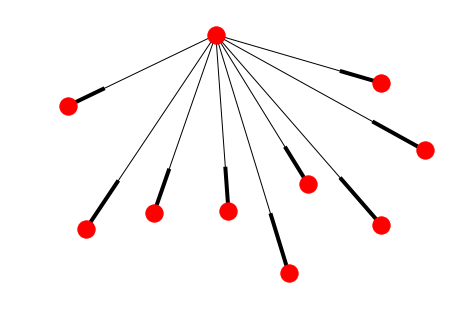

In [12]:
nx.draw(feature_dependency_graph)